In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [ ]:

def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import matplotlib.pyplot as plt
import math
import fastai

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [1]:
#MODEL_PATH = 'Resnet18_v1'
TRAIN_SRC = './input/train/'
TEST_SRC = './input/test/'
LABELS = './input/train.csv'
SAMPLE_SUB = './input/sample_submission.csv'
TRAIN = "./input/tmp/train/"
TEST = "./input/tmp/test/"
TRAIN1 = "./input/tmp1/train/"
TEST1 = "./input/tmp1/test/"



## Resize All

In [5]:
from PIL import Image, ImageOps
def resized_square_image(path, name, desired_size):
    in_path = os.path.join(path, name)
    #print(in_path)
    im = Image.open(in_path)
    old_size = im.size  # old_size[0] is in (width, height) format
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    # use thumbnail() or resize() method to resize the input image
    # thumbnail is a in-place operation
    # im.thumbnail(new_size, Image.ANTIALIAS)
    im = im.resize(new_size, Image.ANTIALIAS)
    # create a new image and paste the resized on it
    new_im = Image.new("RGB", (desired_size, desired_size))
    new_im.paste(im, ((desired_size-new_size[0])//2,
                        (desired_size-new_size[1])//2))
    return new_im

In [6]:
def save_resized(path, out_path, name, sz):
    im_resize_path = os.path.join(out_path, name)
    if os.path.exists(im_resize_path):
        return
    else:
        im = resized_square_image(path, name, sz)
        im.save(im_resize_path)

In [7]:
def resize_all(in_path, out_path, sz):
    os.makedirs(out_path, exist_ok=True)
    all_files = os.listdir(in_path)
    
    if len(all_files) > 0:
        with ThreadPoolExecutor(num_cpus()) as e:
            ims = e.map(lambda fname: save_resized(in_path, out_path, fname, sz), all_files)
            for _ in tqdm(ims, total=len(all_files), leave=False): pass

In [120]:
resize_all(TRAIN_SRC, TRAIN, 128)

In [121]:
resize_all(TEST_SRC, TEST, 128)

## Init

In [6]:
arch = resnet34
nw = 8

In [5]:
train_df = pd.read_csv(LABELS).set_index('Image')
unique_labels = np.unique(train_df.Id.values)
labels_dict = dict()
labels_list = []
for i in range(len(unique_labels)):
    labels_dict[unique_labels[i]] = i
    labels_list.append(unique_labels[i])
print("Number of classes: {}".format(len(unique_labels)))
train_names = train_df.index.values
train_df.Id = train_df.Id.apply(lambda x: labels_dict[x])
train_labels = np.asarray(train_df.Id.values)
test_names = [f for f in os.listdir(TEST)]

Number of classes: 5005


## Data analysis

Count for class new_whale: 9664


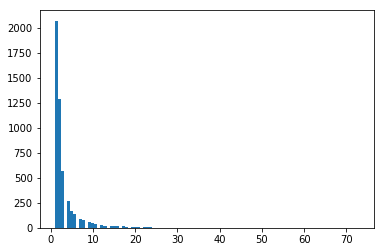

In [7]:
labels_count = train_df.Id.value_counts()
plt.hist(labels_count[1:],bins=100)
print("Count for class new_whale: {}".format(labels_count[0]))

So most of the classes have only one or two sample(s), making train_test_split directly on the data impossible. We'll try a simple fix by duplicating the minor classes so that each class have a minimum of 5 samples.

In [8]:
print(len(train_names))
dup = []
for idx,row in train_df.iterrows():
    if labels_count[row['Id']] < 5:
        dup.extend([idx]*math.ceil((5 - labels_count[row['Id']])/labels_count[row['Id']]))
train_names = np.concatenate([train_names, dup])
train_names = train_names[np.random.RandomState(seed=42).permutation(train_names.shape[0])]
print(len(train_names))

25361
41589


## Data prepare

In [9]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42069)

In [10]:
split = sss.split(train_names, np.zeros(train_names.shape))
train_indexes = []
val_indexes = []
for train_idx, val_idx in sss.split(train_names, np.zeros(train_names.shape)):
    train_indexes = train_idx
    val_indexes = val_idx

In [14]:
print(len(train_indexes), len(val_indexes))

33271 8318


In [11]:
tr_n = [train_names[i] for i in train_indexes]
val_n = [train_names[i] for i in val_indexes]

In [12]:
print(len(tr_n), len(val_n))

33271 8318


In [12]:
#labels = pd.read_csv(LABELS)
#labels["Id"]

In [12]:
avg_width = 0
avg_height = 0
images_widths = []
images_heights = []
for fn in os.listdir(TRAIN)[:1000]:
    img = cv2.imread(os.path.join(TRAIN,fn))
    images_widths.append(img.shape[1])
    images_heights.append(img.shape[0])
avg_width = int(np.mean(images_widths))
avg_height = int(np.mean(images_heights))
print(avg_width, avg_height)

128 128


In [20]:
class HWIDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.train_df = train_df
        super().__init__(fnames, transform, path)

    def get_x(self, i):
        path = os.path.join(self.path, self.fnames[i])
        #return resized_square_image(path, self.sz)
        img = open_image(path)
        # We crop the center of the original image for faster training time
        img = cv2.resize(img, (self.sz, self.sz))
        return img

    def get_y(self, i):
        if (self.path == TEST or self.path == TEST1 or self.path == TEST_SRC): return 0
        return self.train_df.loc[self.fnames[i]]['Id']


    def get_c(self):
        return len(unique_labels)

In [13]:
class HWIDataset1(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.train_df = train_df
        super().__init__(fnames, transform, path)

    def get_x(self, i):
        path = os.path.join(self.path, self.fnames[i])
        #return resized_square_image(path, self.sz)
        img = open_image(path)
        # We crop the center of the original image for faster training time
        #img = cv2.resize(img, (self.sz, self.sz))
        return img


    def get_y(self, i):
        if (self.path == TEST or self.path == TEST1 or self.path == TEST_SRC): return 0
        return self.train_df.loc[self.fnames[i]]['Id']


    def get_c(self):
        return len(unique_labels)

In [15]:
def get_data_128(sz, bs):
    aug_tfms = [RandomRotateZoom(deg=20, zoom=2, stretch=1),
                RandomLighting(0.05, 0.05),
                RandomBlur(blur_strengths=3),
                RandomFlip()]
    tfms = tfms_from_model(arch, sz, crop_type=CropType.CENTER, aug_tfms=aug_tfms)
    ds = ImageData.get_ds(HWIDataset1, (tr_n[:-(len(tr_n) % bs)], TRAIN),
                          (val_n, TRAIN), tfms, test=(test_names, TEST))
    md = ImageData("./", ds, bs, num_workers=nw, classes=None)
    return md

In [14]:
def get_data_256(sz, bs):
    aug_tfms = [RandomRotateZoom(deg=20, zoom=2, stretch=1),
                RandomLighting(0.05, 0.05),
                RandomBlur(blur_strengths=3),
                RandomFlip()]
    tfms = tfms_from_model(arch, sz, crop_type=CropType.CENTER, aug_tfms=aug_tfms)
    ds = ImageData.get_ds(HWIDataset1, (tr_n[:-(len(tr_n) % bs)], TRAIN1),
                          (val_n, TRAIN1), tfms, test=(test_names, TEST1))
    md = ImageData("./", ds, bs, num_workers=nw, classes=None)
    return md

In [16]:
def get_data(sz, bs):
    aug_tfms = [RandomRotateZoom(deg=20, zoom=2, stretch=1),
                RandomLighting(0.05, 0.05),
                RandomBlur(blur_strengths=3),
                RandomFlip()]
    tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
    ds = ImageData.get_ds(HWIDataset, (tr_n[:-(len(tr_n) % bs)], TRAIN1),
                          (val_n, TRAIN1), tfms, test=(test_names, TEST1))
    md = ImageData("./", ds, bs, num_workers=nw, classes=None)
    return md

## Resize images

## Learner

In [122]:
batch_size = 64
md = get_data(128, batch_size)

In [132]:
md.classes

In [123]:
x, y = next(iter(md.val_dl))


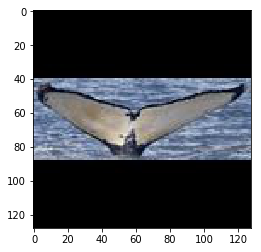

In [131]:
plt.imshow(md.val_ds.denorm(to_np(x))[4])

In [135]:
arch

<function torchvision.models.resnet.resnet34(pretrained=False, **kwargs)>

In [22]:
learn = ConvLearner.pretrained(arch, md, ps=0.5, pretrained=True) 
learn.opt_fn = optim.Adam

NameError: name 'md' is not defined

### Find Lr

 74%|███████▍  | 384/519 [03:02<01:02,  2.16it/s, loss=26.9]

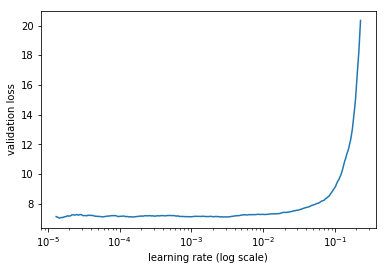

In [149]:
learn.lr_find()
learn.sched.plot()

In [142]:
lr = 3e-2

In [143]:
learn.fit(lr, 1)

epoch      trn_loss   val_loss   accuracy                    
    0      8.223836   7.782833   0.226737  


[7.7828331710226575, 0.22673719626947444]

In [144]:
learn.save("34_fit_2")

### Load and start

In [21]:
#learn.load("resnet19_im_4_20_16_cyc_1")
#learn.load("resnet19_1_20_16")

In [145]:
learn.unfreeze()

In [147]:
lrs = np.array([lr/10, lr/20, lr/40])

In [148]:
learn.fit(lrs, 1, cycle_len=2, use_clr=(10, 5), cycle_save_name="rn34_im_2_10_5")

epoch      trn_loss   val_loss   accuracy                    
    0      7.297569   7.780459   0.225775  
    1      7.122586   7.486302   0.226978                    


[7.4863022945052755, 0.22697763868351628]

In [151]:
lr = 1e-5
lrs = np.array([lr/9, lr/3, lr])

### Let's try to get to 0.4 acc

In [153]:
sz = 256
resize_all(TRAIN_SRC, TRAIN1, int(sz*1.3))

In [156]:
resize_all(TEST_SRC, TEST1, int(sz*1.3))

In [159]:
data = get_data1(256,64)

In [160]:
learn.set_data(data)

In [162]:
learn.lr_find()
learn.sched.plot()

 10%|█         | 52/519 [00:25<03:16,  2.37it/s, loss=7.14]

KeyboardInterrupt: 

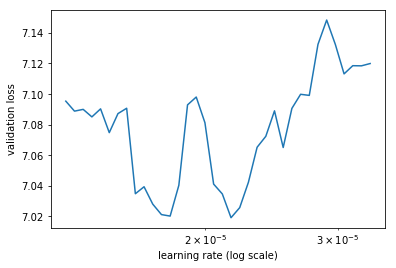

In [163]:
learn.sched.plot()

In [164]:
lr = 1e-5
lrs = np.array([lr/9, lr/3, lr])

In [165]:
learn.fit(lrs, 1, cycle_len=2, use_clr=(10, 5), cycle_save_name="rn34_im_2_10_5_3")

epoch      trn_loss   val_loss   accuracy                    
    0      7.124314   7.486761   0.226978  
    1      7.105865   7.486585   0.226978                    


[7.486584647339851, 0.22697763868351628]

In [133]:
def predict_and_save(pred_file) :
    preds_t,y_t = learn.TTA(is_test=True,n_aug=8)
    preds_t = np.stack(preds_t, axis=-1)
    preds_t = np.exp(preds_t)
    preds_t = preds_t.mean(axis=-1)
    sample_df = pd.read_csv(SAMPLE_SUB)
    sample_list = list(sample_df.Image)
    pred_list = [[labels_list[i] for i in p.argsort()[-5:][::-1]] for p in preds_t]
    pred_dic = dict((key, value) for (key, value) in zip(learn.data.test_ds.fnames,pred_list))
    pred_list_cor = [' '.join(pred_dic[id]) for id in sample_list]
    df = pd.DataFrame({'Image':sample_list,'Id': pred_list_cor})
    df.to_csv(pred_file, header=True, index=False, compression="gzip")
    return df

def submit_to_kaggle(pred_file, message):
    !kaggle competitions submit -c humpback-whale-identification -f {pred_file} -m \"{message}\"

In [ ]:
df = predict_and_save("submission.csv")
df.head()

In [ ]:
submit_to_kaggle("submission.csv", "1st")

### Day 2 - aim for 0.38 acc

In [28]:
learn.load("acc_0_30_tta_subm1")
learn.unfreeze()

 73%|███████▎  | 381/519 [03:14<01:04,  2.15it/s, loss=17.8]

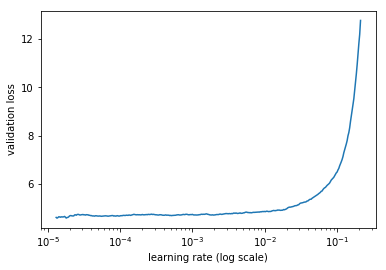

In [26]:
learn.lr_find()
learn.sched.plot()

In [29]:
lr = 5e-5
lrs = np.array([lr/10, lr/20, lr/40])

In [31]:
learn.fit(lrs, 1, cycle_len=1, use_clr=(10, 5), cycle_save_name="resnet19_im_4_20_16_2")

epoch      trn_loss   val_loss   accuracy                    
    0      4.67477    6.738342   0.298149  


[6.738341741935654, 0.29814859344054084]

# Take 2


In [18]:
save_prefix = "2_resnet34"

In [21]:
big_data = get_data(min(avg_width,avg_height),64)
learn = ConvLearner.pretrained(arch, big_data, ps=0.5) 
learn.opt_fn = optim.Adam

In [183]:
data = get_data_128(128, bs=64)
learn.set_data(data)

In [184]:
lr = 5e-2
learn.fit(lr, 1)

epoch      trn_loss   val_loss   accuracy                    
    0      8.783577   7.883649   0.226978  


[7.883649254280892, 0.22697763868351628]

 75%|███████▌  | 390/519 [03:03<00:55,  2.30it/s, loss=28.6]

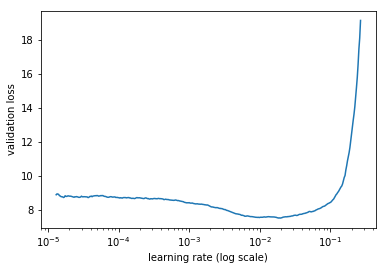

In [174]:
#learn.lr_find()
#learn.sched.plot()

In [185]:
data = get_data_256(256, bs=64)
learn.set_data(data)

In [188]:
learn.unfreeze()
lr = 5e-2
lrs = np.array([lr/10, lr/5, lr])
learn.fit(lrs, 1, cycle_len=2, use_clr=(10, 5), cycle_save_name=f"{save_prefix}_1_10_5")

epoch      trn_loss   val_loss   accuracy                    
    0      9.420278   945.338552 0.225415  
    1      7.523333   7.485279   0.226978                    


[7.485279405996988, 0.22697763868351628]

In [190]:
data = get_data(256, bs=64)
learn.set_data(data)
learn.unfreeze()
lr = 5e-2
lrs = np.array([lr/10, lr/5, lr])
learn.fit(lrs, 2, cycle_len=2, use_clr=(10, 5), cycle_save_name=f"{save_prefix}_2_10_5")

epoch      trn_loss   val_loss   accuracy                    
    0      9.269362   24214.485062 0.226377  
    1      7.472522   10812.999423 0.226978                  
 12%|█▏        | 60/519 [01:27<10:53,  1.42s/it, loss=7.46]

KeyboardInterrupt: 

In [191]:
learn.freeze_to(-1)

In [193]:
learn.fit(5e-4, 1)

epoch      trn_loss   val_loss   accuracy                    
    0      8.013109   7.875371   0.226737  


[7.87537089549856, 0.22673719626947444]

In [194]:
learn.fit(5e-4, 1)

epoch      trn_loss   val_loss   accuracy                    
    0      7.757692   7.829172   0.226737  


[7.829171690581997, 0.22673719626947444]

In [195]:
learn.freeze_to(-2)

In [196]:
learn.fit(5e-4, 1)

epoch      trn_loss   val_loss   accuracy                    
    0      7.567897   24349.412204 0.226978  


[24349.41220389504, 0.22697763868351628]

In [199]:
learn.unfreeze()

 75%|███████▍  | 387/519 [09:18<03:06,  1.41s/it, loss=28]  

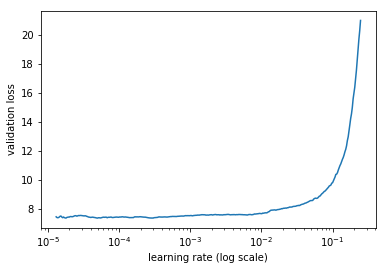

In [200]:
learn.lr_find()
learn.sched.plot()

In [201]:
learn.freeze_to(2)

In [202]:
lr = 1e-5
lrs = np.array([lr/5, lr/10, lr])
learn.fit(lrs, 1, cycle_len=1, use_clr=(10, 5), cycle_save_name=f"{save_prefix}_1_10_5")

epoch      trn_loss   val_loss   accuracy                    
    0      7.397911   87135.991837 0.226978  


[87135.99183690992, 0.22697763868351628]

In [22]:
learn.load("weird_loss")

In [208]:
learn.save("weird_loss")

In [24]:
data = get_data(300, bs=64)
learn.set_data(data)
learn.unfreeze()

In [ ]:
lr = 1e-4
lrs = np.array([lr/100, lr/10, lr])
learn.fit(lrs, 1, cycle_len=2, use_clr=(20, 10), cycle_save_name=f"{save_prefix}_2_1_20_10")

 76%|███████▌  | 393/519 [12:31<03:57,  1.89s/it, loss=7.54]